In [87]:
path_data = '../01 data/'
epochs=50
batch_size=200
monitor = 'mae'
mode = 'min'
patience = 10
test_score, val_score = 'mae', 'val_mae'

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer, mean_absolute_error as mae
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data preparation

In [11]:
# Load data
trainSet = pd.read_csv(path_data + 'train.csv')
testSet = pd.read_csv(path_data + 'test.csv')
print(trainSet.shape)
trainSet.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
# Feature selection
# Train set
selected_features = [
    'OverallQual', 'BsmtQual', 'LandSlope',
    'GarageCars', 'Exterior2nd', 'KitchenQual', 'GrLivArea'
]
trainSet = trainSet[['SalePrice'] + selected_features]

# Test set
testSet = testSet[selected_features]

print(trainSet.shape)
trainSet.head()

(1460, 8)


,SalePrice,OverallQual,BsmtQual,LandSlope,GarageCars,Exterior2nd,KitchenQual,GrLivArea
0,208500,7,Gd,Gtl,2,VinylSd,Gd,1710
1,181500,6,Gd,Gtl,2,MetalSd,TA,1262
2,223500,7,Gd,Gtl,2,VinylSd,Gd,1786
3,140000,7,TA,Gtl,3,Wd Shng,Gd,1717
4,250000,8,Gd,Gtl,3,VinylSd,Gd,2198


In [18]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SalePrice    1460 non-null   int64 
 1   OverallQual  1460 non-null   int64 
 2   BsmtQual     1460 non-null   object
 3   LandSlope    1460 non-null   object
 4   GarageCars   1460 non-null   int64 
 5   Exterior2nd  1460 non-null   object
 6   KitchenQual  1460 non-null   object
 7   GrLivArea    1460 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 91.4+ KB


In [14]:
testSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OverallQual  1459 non-null   int64  
 1   BsmtQual     1415 non-null   object 
 2   LandSlope    1459 non-null   object 
 3   GarageCars   1458 non-null   float64
 4   Exterior2nd  1458 non-null   object 
 5   KitchenQual  1458 non-null   object 
 6   GrLivArea    1459 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 79.9+ KB


In [24]:
# Train
# Fill na
trainSet['BsmtQual'] = trainSet['BsmtQual'].fillna(trainSet['BsmtQual'].value_counts().idxmax())

# One hot encoding
trainSet = pd.get_dummies(trainSet)

# Feature selection
selected_features_2 = [
    'OverallQual', 'BsmtQual_Ex', 'LandSlope_Gtl', 'GarageCars',
    'Exterior2nd_CmentBd', 'KitchenQual_Ex', 'GrLivArea'
]
trainSet = trainSet[['SalePrice'] + selected_features_2]

# Test
na_features = ['BsmtQual', 'Exterior2nd', 'KitchenQual']
for f in na_features:
    testSet[f] = testSet[f].fillna(trainSet[f].value_counts().idxmax())
testSet['GarageCars'] = testSet['GarageCars'].fillna(trainSet['GarageCars'].median())

testSet = pd.get_dummies(testSet)

testSet = testSet[selected_features_2]

print(trainSet.shape)
trainSet.head(3)

(1460, 8)


,SalePrice,OverallQual,BsmtQual_Ex,LandSlope_Gtl,GarageCars,Exterior2nd_CmentBd,KitchenQual_Ex,GrLivArea
0,208500,7,0,1,2,0,0,1710
1,181500,6,0,1,2,0,0,1262
2,223500,7,0,1,2,0,0,1786


In [25]:
# train validation split
X_train, X_val, y_train, y_val = train_test_split(
    trainSet.drop(columns=['SalePrice']),
    trainSet['SalePrice'],
    test_size=0.2,
    random_state=123
)

In [27]:
X_train.to_csv('../03 outputs/01/X_train.csv', index=False)
X_val.to_csv('../03 outputs/01/X_val.csv', index=False)
y_train.to_csv('../03 outputs/01/y_train.csv', index=False)
y_val.to_csv('../03 outputs/01/y_val.csv', index=False)
testSet.to_csv('../03 outputs/01/testSet.csv', index=False)

# Training models

In [62]:
def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2, seed=123))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    opt = Adam(learning_rate=1e-3)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics='mae')

    return model

In [34]:
# Set callbacks
def create_callbacks(model_name, monitor, mode, patience):
    # Early stopping
    es = EarlyStopping(
        monitor=monitor, mode=mode, verbose=0, patience=patience, restore_best_weights=True
    )

    # Checkpoint
    checkpoint = ModelCheckpoint(
        filepath=model_name,
        monitor=monitor,
        mode=mode,
        save_best_only=True
    )

    return es, checkpoint

In [88]:
# Fit model
def fit_model(model, es, checkpoint):
    model_history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, es],
        verbose=1,
    )
    return model, model_history

In [36]:
# Plot model history
def plot_history(model_history, test_score, val_score):
    # Visualize the CNN training history
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    # Accuracy
    ax[0].plot(model_history.history[test_score])
    ax[0].plot(model_history.history[val_score])
    ax[0].set_title(test_score)
    ax[0].set_ylabel(test_score)
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper left')

    # Loss
    ax[1].plot(model_history.history['loss'])
    ax[1].plot(model_history.history['val_loss'])
    ax[1].set_title('loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()

In [89]:
# Create callbacks
es, checkpoint = create_callbacks('../03 output/regression_model.hdf5', monitor, mode, patience)
# Build model architecture
model = build_model()
# Fit the model
model, model_history = fit_model(model, es, checkpoint)

Epoch 1/50
6/6 [==============================] - 1s 39ms/step - loss: 38984830976.0000 - mae: 180685.7969 - val_loss: 39184637952.0000 - val_mae: 181679.1719
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 38961758208.0000 - mae: 180629.7031 - val_loss: 39160193024.0000 - val_mae: 181618.4375
Epoch 3/50
6/6 [==============================] - 0s 14ms/step - loss: 38939340800.0000 - mae: 180571.8750 - val_loss: 39140966400.0000 - val_mae: 181570.6719
Epoch 4/50


c:\Users\Danamas\anaconda3\envs\venv_38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 15ms/step - loss: 38918844416.0000 - mae: 180520.6250 - val_loss: 39121367040.0000 - val_mae: 181521.9375
Epoch 5/50
6/6 [==============================] - 0s 15ms/step - loss: 38898475008.0000 - mae: 180468.8750 - val_loss: 39098048512.0000 - val_mae: 181463.9375
Epoch 6/50
6/6 [==============================] - 0s 14ms/step - loss: 38867288064.0000 - mae: 180395.1562 - val_loss: 39071014912.0000 - val_mae: 181396.7344
Epoch 7/50
6/6 [==============================] - 0s 14ms/step - loss: 38841581568.0000 - mae: 180327.3438 - val_loss: 39038476288.0000 - val_mae: 181315.7656
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 38803468288.0000 - mae: 180234.3594 - val_loss: 38988488704.0000 - val_mae: 181191.2812
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 38750666752.0000 - mae: 180105.2969 - val_loss: 38922911744.0000 - val_mae: 181027.9219
Epoch 10/50
6/6 [==============================] - 0s 13m

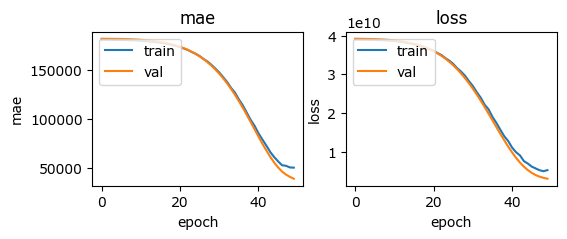

In [90]:
# Plot model history
plot_history(model_history, test_score, val_score)

# Invoke prediction

In [102]:
# Train
pred_train = pd.DataFrame(y_train)
pred_train['pred'] = model.predict(X_train)
pred_train.columns = ['true', 'pred']
pred_train['pred'] = (round(pred_train['pred'], 0)).astype(int)

# Val
pred_val = pd.DataFrame(y_val)
pred_val['pred'] = model.predict(X_val)
pred_val.columns = ['true', 'pred']
pred_val['pred'] = (round(pred_val['pred'], 0)).astype(int)

# Test
pred_test = model.predict(testSet)
pred_test = pd.DataFrame(pred_test)
pred_test.columns = ['pred']
pred_test = (round(pred_test['pred'], 0)).astype(int)

pred_train.head(3)

,true,pred
318,260000,281244
580,181900,152204
961,272000,305107


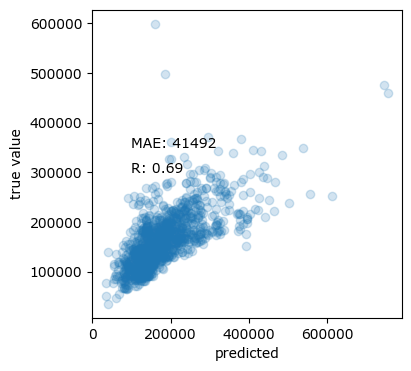

In [105]:
# Scatter plot true and predicted values
plt.figure(figsize=(4,4))
plt.scatter(pred_train['true'], pred_train['pred'], alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 350000, 'MAE: ' + str(round(mae(pred_train['true'], pred_train['pred']))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(pred_train['true'], pred_train['pred'])[0,1],2)))
plt.show()

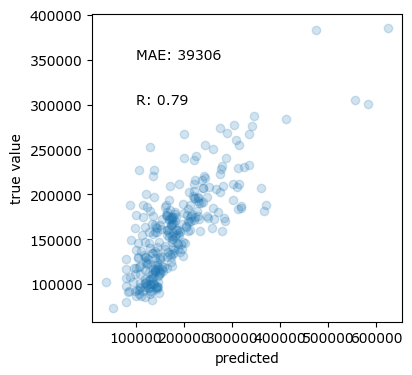

In [106]:
# Scatter plot true and predicted values
plt.figure(figsize=(4,4))
plt.scatter(pred_val['true'], pred_val['pred'], alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
plt.text(100000, 350000, 'MAE: ' + str(round(mae(pred_val['true'], pred_val['pred']))))
plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(pred_val['true'], pred_val['pred'])[0,1],2)))
plt.show()

In [109]:
# Save
pred_train.to_csv('../03 outputs/01/pred_train.csv')
pred_val.to_csv('../03 outputs/01/pred_val.csv')
pred_test.to_csv('../03 outputs/01/pred_test.csv')